# Unit 2 Lesson 5 Challenge: Validating a linear regression

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
from sklearn import preprocessing
import math
import statsmodels.formula.api as smf
import scipy.stats as stats
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
ga_data = pd.read_csv('GAcrime2013.csv')
ny_data = pd.read_csv('offenses_known_to_law_enforcement1.csv')

### Exploring the data

In [3]:
ga_data.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Abbeville,"2,888",3,0,nan,0,2,1,22,3,16,3,0.000
1,Adairsville,"4,686",13,0,nan,0,1,12,52,15,31,6,0.000
2,Adel,"5,240",18,0,nan,5,5,8,189,64,121,4,0.000
3,Adrian,656,0,0,nan,0,0,0,2,0,2,0,0.000
4,Alapaha,646,5,0,nan,0,1,4,6,0,6,0,0.000


In [4]:
ga_data.describe()

,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Arson3
count,253.000,0.000,253.000,176.000
mean,1.115,nan,3.146,2.125
std,5.960,nan,9.060,7.627
min,0.000,nan,0.000,0.000
25%,0.000,nan,0.000,0.000
50%,0.000,nan,0.000,0.000
75%,0.000,nan,2.000,1.000
max,84.000,nan,105.000,71.000


### Data Cleaning

In [5]:
ga_data = ga_data.drop(['Rape\n(revised\ndefinition)1'], axis =1)
ny_data = ny_data.drop(['Rape\n(revised\ndefinition)1'], axis =1)

In [6]:
ga_data.columns = ['City', 'Population', 'ViolentCrime', 'Murder', 'Rape2', 'Robbery', 'AggAssault',
                   'PropCrime', 'Burglary', 'Larceny', 'AutoTheft', 'Arson']
ny_data.columns = ['City', 'Population', 'ViolentCrime', 'Murder', 'Rape2', 'Robbery', 'AggAssault',
                    'PropCrime', 'Burglary', 'Larceny', 'AutoTheft', 'Arson']

In [7]:
ga_data = ga_data.fillna(0)
ny_data = ny_data.fillna(0)

In [8]:
ga_data.head(10)

,City,Population,ViolentCrime,Murder,Rape2,Robbery,AggAssault,PropCrime,Burglary,Larceny,AutoTheft,Arson
0,Abbeville,"2,888",3,0,0,2,1,22,3,16,3,0.000
1,Adairsville,"4,686",13,0,0,1,12,52,15,31,6,0.000
2,Adel,"5,240",18,0,5,5,8,189,64,121,4,0.000
3,Adrian,656,0,0,0,0,0,2,0,2,0,0.000
4,Alapaha,646,5,0,0,1,4,6,0,6,0,0.000
5,Albany,"77,365",749,8,21,183,537,"4,661","1,319","3,169",173,19.000
6,Alma,"3,529",24,0,2,8,14,208,45,158,5,0.000
7,Alpharetta,"63,442",47,2,2,23,20,"1,228",128,"1,074",26,2.000
8,Alto,"1,159",0,0,0,0,0,28,16,10,2,0.000
9,Americus,"16,190",231,0,0,40,191,"1,246",605,613,28,1.000


In [9]:
# Need to convert the column's data from strings for NY

ga_data['Arson'] = ga_data['Arson'].astype(int)
ga_data['Robbery'] = ga_data['Robbery'].str.replace(',', '')
ga_data['Population'] = ga_data['Population'].str.replace(',', '')
ga_data['Robbery'] = ga_data['Robbery'].astype(int)
ga_data['Population'] = ga_data['Population'].astype(int)
ga_data['PropCrime'] = ga_data['PropCrime'].str.replace(',', '')
ga_data['Larceny'] = ga_data['Larceny'].str.replace(',', '')
ga_data['AutoTheft'] = ga_data['AutoTheft'].str.replace(',', '')
ga_data['PropCrime'] = ga_data['PropCrime'].astype(int)
ga_data['Rape2'] = ga_data['Rape2'].astype(int)
ga_data['Murder'] = ga_data['Murder'].astype(int)
ga_data['Burglary'] = ga_data['Burglary'].str.replace(',', '')
ga_data['Burglary'] = ga_data['Burglary'].astype(int)
ga_data['Larceny'] = ga_data['Larceny'].astype(int)
ga_data['AutoTheft'] = ga_data['AutoTheft'].astype(int)

In [10]:
# Need to convert the column's data from strings for ny

ny_data['Arson'] = ny_data['Arson'].astype(int)
ny_data['Robbery'] = ny_data['Robbery'].str.replace(',', '')
ny_data['Population'] = ny_data['Population'].str.replace(',', '')
ny_data['Robbery'] = ny_data['Robbery'].astype(int)
ny_data['Population'] = ny_data['Population'].astype(int)
ny_data['PropCrime'] = ny_data['PropCrime'].str.replace(',', '')
ny_data['Larceny'] = ny_data['Larceny'].str.replace(',', '')
ny_data['AutoTheft'] = ny_data['AutoTheft'].str.replace(',', '')
ny_data['Rape2'] = ny_data['Rape2'].str.replace(',', '')
ny_data['PropCrime'] = ny_data['PropCrime'].astype(int)
ny_data['Rape2'] = ny_data['Rape2'].astype(int)
ny_data['Murder'] = ny_data['Murder'].astype(int)
ny_data['Burglary'] = ny_data['Burglary'].str.replace(',', '')
ny_data['Burglary'] = ny_data['Burglary'].astype(int)
ny_data['Larceny'] = ny_data['Larceny'].astype(int)
ny_data['AutoTheft'] = ny_data['AutoTheft'].astype(int)

In [11]:
ny_data = ny_data[ny_data['PropCrime']< ny_data['PropCrime'].quantile(0.95)]

In [12]:
ny_data['Rape_bi'] = ny_data['Rape2'].apply(lambda x: 1 if x >= 1 else 0)
ny_data['Robbery_bi'] = ny_data['Robbery'].apply(lambda x: 1 if x >= 1 else 0)
ny_data['Murder_bi'] = ny_data['Murder'].apply(lambda x: 1 if x >= 1 else 0)
ny_data['Larceny_bi'] = ny_data['Larceny'].apply(lambda x: 1 if x >= 1 else 0)
ny_data['AutoTheft_bi'] = ny_data['AutoTheft'].apply(lambda x: 1 if x >= 1 else 0)
ny_data['Popx2'] = ny_data['Population']** 2

ga_data['Rape_bi'] = ga_data['Rape2'].apply(lambda x: 1 if x >= 1 else 0)
ga_data['Robbery_bi'] = ga_data['Robbery'].apply(lambda x: 1 if x >= 1 else 0)
ga_data['Murder_bi'] = ga_data['Murder'].apply(lambda x: 1 if x >= 1 else 0)
ga_data['Larceny_bi'] = ga_data['Larceny'].apply(lambda x: 1 if x >= 1 else 0)
ga_data['AutoTheft_bi'] = ga_data['AutoTheft'].apply(lambda x: 1 if x >= 1 else 0)
ga_data['Popx2'] = ga_data['Population']** 2
new_ny_data_col = ["Population", "Rape2", "PropCrime", 'Robbery', 'Rape_bi', 'Robbery_bi', 'Popx2',
                    'Murder', 'Murder_bi',  'AutoTheft_bi' , 'AutoTheft', 'Larceny_bi', 'Larceny']
new_ny_data = ny_data[new_ny_data_col]
new_ga_data_col = ["Population", "Rape2", "PropCrime", 'Robbery', 'Rape_bi', 'Robbery_bi', 'Popx2',
                    'Murder', 'Murder_bi',  'AutoTheft_bi' , 'AutoTheft', 'Larceny_bi', 'Larceny']
new_ga_data = ga_data[new_ny_data_col]

###  Creating a new feature and fitting the model

In [13]:
regr = linear_model.LinearRegression()
ny_Y = ny_data['PropCrime'].values.reshape(-1, 1)
ny_X = new_ny_data[["Population", "Rape2", "Robbery", 'Rape_bi', 'Robbery_bi', 'Popx2', 'Murder',
                  'Murder_bi', 'AutoTheft_bi' , 'AutoTheft', 'Larceny_bi', 'Larceny']]
regr.fit(ny_X, ny_Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(ny_X, ny_Y))


Coefficients: 
 [[  2.86958905e-04   4.15659223e+00   9.01433563e-01  -8.92755374e-01
    1.22516993e+00  -3.24701332e-09  -9.45629186e+00   8.80678146e+00
    1.46246556e+00   1.47744350e+00   1.78852333e+00   1.09463806e+00]]

Intercept: 
 [-0.222691]

R-squared:
0.995693747904


In [14]:
ga_y = new_ga_data['PropCrime'].values.reshape(-1, 1)
ga_x = new_ga_data[["Population", "Rape2", "Robbery", 'Rape_bi', 'Robbery_bi', 'Popx2', 'Murder',
                  'Murder_bi', 'AutoTheft_bi' , 'AutoTheft', 'Larceny_bi', 'Larceny']]

regr.score(ga_x,  ga_y)

0.99442918620491771

In [15]:
# This seemed to score far too well
score_ny = cross_val_score(regr, ny_X, ny_Y, cv=10)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score_ny.mean(), score_ny.std() * 2))
score_ga = cross_val_score(regr, ga_x, ga_y, cv=10)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_ga.mean(), score_ga.std() * 2))

Unweighted Accuracy: 0.99 (+/- 0.01)
Weighted Accuracy: 0.99 (+/- 0.01)


The model scored a .995 Rsquared on the NY datasets and  a .994 on the GA it also had a 99% +/-1 for accuracy, which was a huge surprise because I thought for sure I was overfitting by added so many features.

In [16]:
linear_formula = 'new_ny_data.PropCrime ~ Population + Rape2 + Robbery + Rape_bi + Robbery_bi + Popx2 + Murder+Murder_bi + AutoTheft_bi + AutoTheft + Larceny_bi + Larceny'
lm = smf.ols(formula= linear_formula, data=new_ny_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     new_ny_data.PropCrime   R-squared:                       0.996
Model:                               OLS   Adj. R-squared:                  0.996
Method:                    Least Squares   F-statistic:                     6108.
Date:                   Wed, 30 May 2018   Prob (F-statistic):               0.00
Time:                           15:27:34   Log-Likelihood:                -1428.3
No. Observations:                    330   AIC:                             2883.
Df Residuals:                        317   BIC:                             2932.
Df Model:                             12                                         
Covariance Type:               nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.2227      7.077     -0.031      0.975     -14.147      13.701
Population       0.0003      0.000      1.864      0.063    -1.6e-05       0.001
Rape2            4.1566      0.566      7.342      0.000       3.043       5.270
Robbery          0.9014      0.188      4.794      0.000       0.532       1.271
Rape_bi         -0.8928      2.874     -0.311      0.756      -6.548       4.762
Robbery_bi       1.2252      2.654      0.462      0.645      -3.997       6.448
Popx2        -3.247e-09   2.77e-09     -1.170      0.243   -8.71e-09    2.21e-09
Murder          -9.4563      3.316     -2.852      0.005     -15.981      -2.932
Murder_bi        8.8068      5.471      1.610      0.108      -1.957      19.570
AutoTheft_bi     1.4625      2.685      0.545      0.586      -3.821       6.746
AutoTheft        1.4774      0.205      7.219      0.000       1.075       1.880
Larceny_bi       1.7885      7.391      0.242      0.809     -12.753      16.330
Larceny          1.0946      0.009    122.177      0.000       1.077       1.112
==============================================================================
Omnibus:                       96.004   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1092.750
Skew:                           0.835   Prob(JB):                    5.16e-238
Kurtosis:                      11.757   Cond. No.                     4.65e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.65e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Rape_bi, robbery_bi, Popx2, Murder_bi, AutoTheft_bi and Larceny_bi p-values are much higher than 0.05 and population is a little bit higher, but I am very hesitant to remove population it seems as though it would hurt the model to remove this feature.

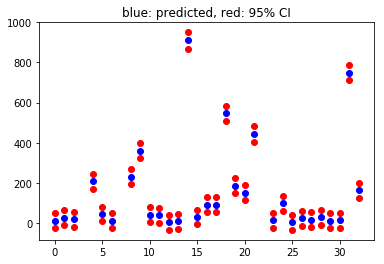

In [17]:
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u[0:30], 'o', color='r')
plt.plot(iv_l[0:30], 'o', color='r')
plt.plot(lm.fittedvalues[0:30], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

In [18]:
# decided to remove the Rape2 feature because of the high pvalue and we will see the new results
ny_Y2 = ny_data['PropCrime'].values.reshape(-1, 1)
ny_X2 = new_ny_data[["Population", "Rape2", "Robbery", 'Murder', 'AutoTheft', 'Larceny']]
regr.fit(ny_X2, ny_Y2)
new_ed_pred = regr.predict(ny_X2).ravel()
new_actual = new_ny_data['PropCrime']
# Calculate the error, also called the residual.
new_ed_res = new_actual - new_ed_pred
# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(ny_X2, ny_Y2))


Coefficients: 
 [[  2.74330560e-04   4.24692186e+00   7.58769410e-01  -5.59731217e+00
    1.52993658e+00   1.09785328e+00]]

Intercept: 
 [ 2.49191856]

R-squared:
0.995629812742


In [19]:
ga_y2 = new_ga_data['PropCrime'].values.reshape(-1, 1)
ga_x2 = new_ga_data[["Population", "Rape2", "Robbery", 'Murder', 'AutoTheft', 'Larceny']]

regr.score(ga_x2,  ga_y2)

0.99511793597224096

In [20]:
score_ny2 = cross_val_score(regr, ny_X, ny_Y, cv=10)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score_ny.mean(), score_ny.std() * 2))
score_ga2 = cross_val_score(regr, ga_x2, ga_y2, cv=10)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_ga2.mean(), score_ga2.std() * 2))

Unweighted Accuracy: 0.99 (+/- 0.01)
Weighted Accuracy: 0.99 (+/- 0.01)


The model scored a .995 Rsquared on both datasets and had a 99% +/-1 for accuracy

In [21]:
new_linear_formula = 'new_ny_data.PropCrime ~ Population + Rape2 + Robbery + Murder + AutoTheft + Larceny'
new_lm = smf.ols(formula= new_linear_formula, data=new_ny_data).fit()
new_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     new_ny_data.PropCrime   R-squared:                       0.996
Model:                               OLS   Adj. R-squared:                  0.996
Method:                    Least Squares   F-statistic:                 1.226e+04
Date:                   Wed, 30 May 2018   Prob (F-statistic):               0.00
Time:                           15:27:34   Log-Likelihood:                -1430.8
No. Observations:                    330   AIC:                             2876.
Df Residuals:                        323   BIC:                             2902.
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4919      1.422      1.752      0.081      -0.306       5.290
Population     0.0003      0.000      1.895      0.059   -1.04e-05       0.001
Rape2          4.2469      0.507      8.370      0.000       3.249       5.245
Robbery        0.7588      0.164      4.615      0.000       0.435       1.082
Murder        -5.5973      2.398     -2.335      0.020     -10.314      -0.881
AutoTheft      1.5299      0.199      7.676      0.000       1.138       1.922
Larceny        1.0979      0.008    130.038      0.000       1.081       1.114
==============================================================================
Omnibus:                       94.322   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              843.136
Skew:                           0.896   Prob(JB):                    8.23e-184
Kurtosis:                      10.623   Cond. No.                     3.91e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.91e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

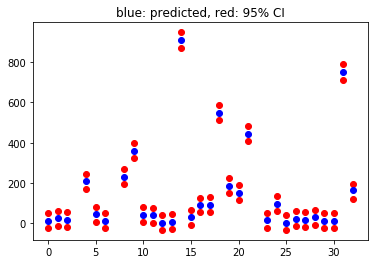

In [22]:
prstd, iv_l, iv_u = wls_prediction_std(new_lm)

plt.figure()
plt.plot(iv_u[0:30], 'o', color='r')
plt.plot(iv_l[0:30], 'o', color='r')
plt.plot(lm.fittedvalues[0:30], 'o', color='b')
plt.title('blue: predicted, red: 95% CI')
plt.show()

## Recap

My original model had a high Rsquared (.995) for both datasets however it had extremely high p-values for many of the features, removing those features simplified my model and improved my Rsquare for the GA dataset. The accuracy for both models were also high for both datasets at 99%.